This notebook evaluates GNNs for 'is_planar' task. Te difference from the original 'IsPlanar' notebook is the average number of nodes samples of the synthetically generated dataset that's based on `torch_geometric.datasets.FakeDataset`. We'll consider the following settings:
* node features: one hot degree; dataset: avg_degree=2, avg_num_nodes=15
  * GNNs: GCN, SAGE, Conv (see `src/models`)
  * NNs: input - sum of node features (no edges), 4 hidden layers.
* node features: constant; dataset: avg_degree=2, avg_num_nodes=15
  * GNNs: GCN, SAGE, Conv
 
The number of graphs is each dataset is 100k.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataset import FakeDatasetIsPlanar, split_dataset
from visualization import visualize
from model import GCN, SAGE, ConvGNN
from training.train_eval import TrainEval
from training.train_eval_graphless import TrainEvalGraphless

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import OneHotDegree, Constant
from torch_geometric.datasets import FakeDataset
from torch_geometric.nn import GCNConv
from torch import nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import torch
import random
import numpy as np


In [13]:
NUM_GRAPHS = 100000
NUM_EPOCH = 100

# Features: one hot degree, avg_nodes: 15

## GNNs

In [36]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 2
max_degree = 15

one_hot_degree = OneHotDegree(max_degree, cat=False)

ds_onehot = FakeDatasetIsPlanar(num_graphs=NUM_GRAPHS, avg_num_nodes=15, avg_degree=avg_degree,
                               transform=one_hot_degree)
print(f"Planar graphs: {int(ds_onehot.y.sum())}")
ds_onehot

Planar graphs: 31665
CPU times: user 39.5 s, sys: 66.7 ms, total: 39.6 s
Wall time: 39.7 s


FakeDatasetIsPlanar(100000)

In [37]:
ds_onehot[0]

Data(edge_index=[2, 48], y=[1], is_planar=[1], pos=[14, 2], num_nodes=15, x=[15, 16])

In [38]:
onehot_train_loader, onehot_test_loader = split_dataset(ds_onehot)

Number of training graphs: 80000
Number of test graphs: 20000


GCN(
  (conv1): GCNConv(16, 11)
  (conv2): GCNConv(11, 11)
  (conv3): GCNConv(11, 11)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7952, precision=0.8027, recall=0.4660, size=80000.0000, f1=0.5896, Test: accuracy=0.7931, precision=0.8062, recall=0.4657, size=20000.0000, f1=0.5904
Epoch:  02, Train: accuracy=0.8008, precision=0.7503, recall=0.5534, size=80000.0000, f1=0.6369, Test: accuracy=0.7986, precision=0.7516, recall=0.5543, size=20000.0000, f1=0.6380
Epoch:  03, Train: accuracy=0.8004, precision=0.7259, recall=0.5912, size=80000.0000, f1=0.6517, Test: accuracy=0.7969, precision=0.7246, recall=0.5897, size=20000.0000, f1=0.6502
Epoch:  04, Train: accuracy=0.7973, precision=0.6982, recall=0.6308, size=80000.0000, f1=0.6628, Test: accuracy=0.7952, precision=0.6993, recall=0.6319, size=20000.0000, f1=0.6639
Epoch:  05, Train: accuracy=0.7961, precision=0.6848, recall=0.6562, size=80000.0000, f1=0.6702, Test: accuracy=0.7915, precision=0.6

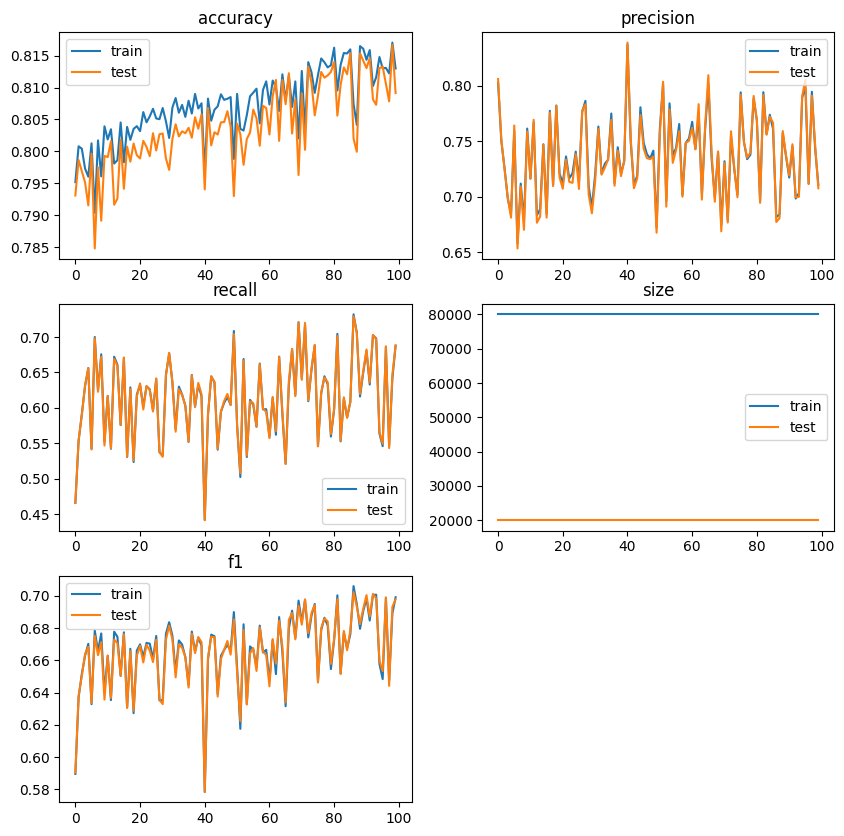

In [39]:
gcn_model = GCN(hidden_channels=11, num_node_features=ds_onehot.num_node_features,
            num_classes=ds_onehot.num_classes)
print(gcn_model)

te = TrainEval(gcn_model)
te.main(NUM_EPOCH, onehot_train_loader, onehot_test_loader)

SAGE(
  (conv1): SAGEConv(16, 11, aggr=mean)
  (conv2): SAGEConv(11, 11, aggr=mean)
  (conv3): SAGEConv(11, 11, aggr=mean)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.8022, precision=0.7491, recall=0.5620, size=80000.0000, f1=0.6422, Test: accuracy=0.7984, precision=0.7474, recall=0.5596, size=20000.0000, f1=0.6400
Epoch:  02, Train: accuracy=0.7998, precision=0.7750, recall=0.5158, size=80000.0000, f1=0.6193, Test: accuracy=0.7987, precision=0.7781, recall=0.5196, size=20000.0000, f1=0.6231
Epoch:  03, Train: accuracy=0.8039, precision=0.7804, recall=0.5276, size=80000.0000, f1=0.6296, Test: accuracy=0.8015, precision=0.7804, recall=0.5290, size=20000.0000, f1=0.6306
Epoch:  04, Train: accuracy=0.8104, precision=0.7573, recall=0.5882, size=80000.0000, f1=0.6621, Test: accuracy=0.8045, precision=0.7476, recall=0.5878, size=20000.0000, f1=0.6582
Epoch:  05, Train: accuracy=0.8132, precision=0.7489, recall=0.6147, size=80000.0000, f1=0.6752,

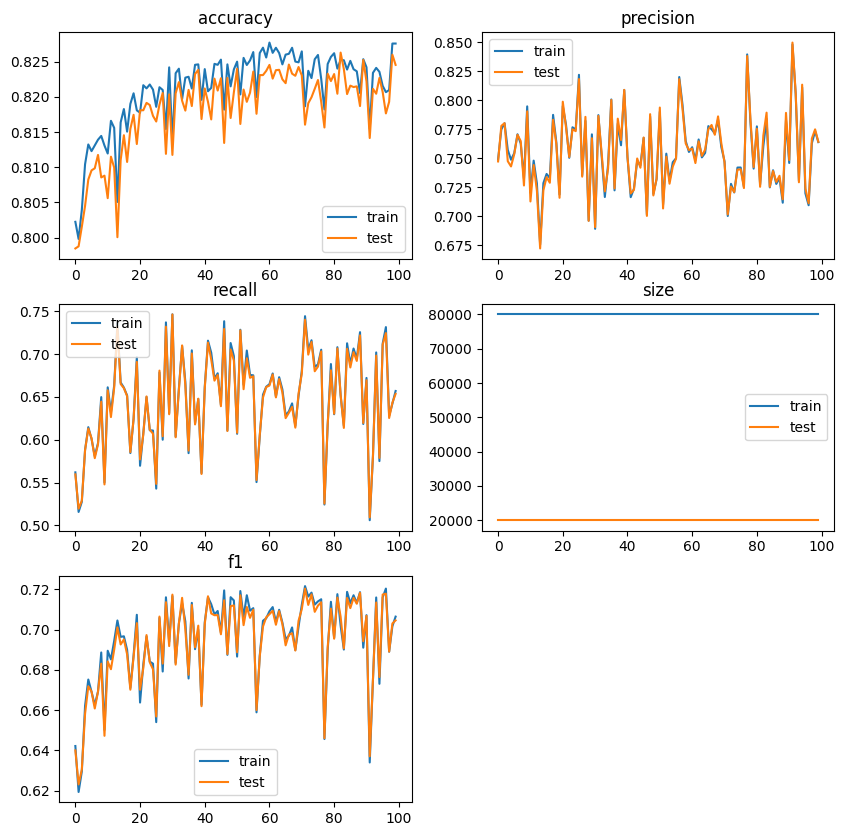

In [40]:
sage_model = SAGE(hidden_channels=11, num_node_features=ds_onehot.num_node_features,
                  num_classes=ds_onehot.num_classes)
print(sage_model)

te = TrainEval(sage_model)
te.main(NUM_EPOCH, onehot_train_loader, onehot_test_loader)

ConvGNN(
  (conv1): GraphConv(16, 11)
  (conv2): GraphConv(11, 11)
  (conv3): GraphConv(11, 11)
  (lin): Linear(in_features=11, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.8041, precision=0.7469, recall=0.5741, size=80000.0000, f1=0.6492, Test: accuracy=0.8009, precision=0.7445, recall=0.5757, size=20000.0000, f1=0.6493
Epoch:  02, Train: accuracy=0.8107, precision=0.7624, recall=0.5817, size=80000.0000, f1=0.6599, Test: accuracy=0.8057, precision=0.7553, recall=0.5814, size=20000.0000, f1=0.6571
Epoch:  03, Train: accuracy=0.8103, precision=0.7837, recall=0.5517, size=80000.0000, f1=0.6475, Test: accuracy=0.8067, precision=0.7792, recall=0.5529, size=20000.0000, f1=0.6468
Epoch:  04, Train: accuracy=0.8116, precision=0.7585, recall=0.5918, size=80000.0000, f1=0.6648, Test: accuracy=0.8073, precision=0.7527, recall=0.5928, size=20000.0000, f1=0.6633
Epoch:  05, Train: accuracy=0.8150, precision=0.7418, recall=0.6351, size=80000.0000, f1=0.6843, Test: accuracy=0.8105, pre

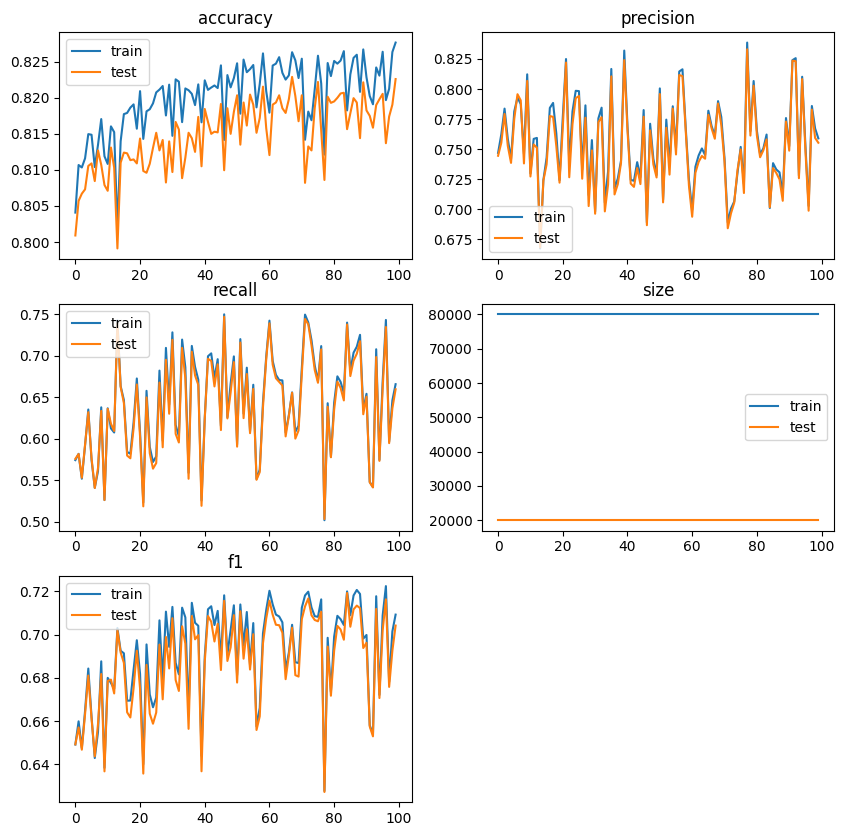

In [41]:
conv_model = ConvGNN(hidden_channels=11, num_node_features=ds_onehot.num_node_features,
                     num_classes=2)
print(conv_model)

te = TrainEval(conv_model)
te.main(NUM_EPOCH, onehot_train_loader, onehot_test_loader)

## NN

Epoch:  01, Train: accuracy=0.8174, precision=0.8115, recall=0.5494, size=80000.0000, f1=0.6552, Test: accuracy=0.8153, precision=0.8112, recall=0.5515, size=20000.0000, f1=0.6566
Epoch:  02, Train: accuracy=0.8213, precision=0.7202, recall=0.7096, size=80000.0000, f1=0.7149, Test: accuracy=0.8166, precision=0.7169, recall=0.7059, size=20000.0000, f1=0.7114
Epoch:  03, Train: accuracy=0.8224, precision=0.7808, recall=0.6083, size=80000.0000, f1=0.6838, Test: accuracy=0.8215, precision=0.7850, recall=0.6091, size=20000.0000, f1=0.6860
Epoch:  04, Train: accuracy=0.8223, precision=0.7833, recall=0.6044, size=80000.0000, f1=0.6823, Test: accuracy=0.8214, precision=0.7871, recall=0.6061, size=20000.0000, f1=0.6848
Epoch:  05, Train: accuracy=0.8209, precision=0.7990, recall=0.5785, size=80000.0000, f1=0.6711, Test: accuracy=0.8179, precision=0.7967, recall=0.5791, size=20000.0000, f1=0.6707
Epoch:  06, Train: accuracy=0.8233, precision=0.7727, recall=0.6237, size=80000.0000, f1=0.6903, Tes

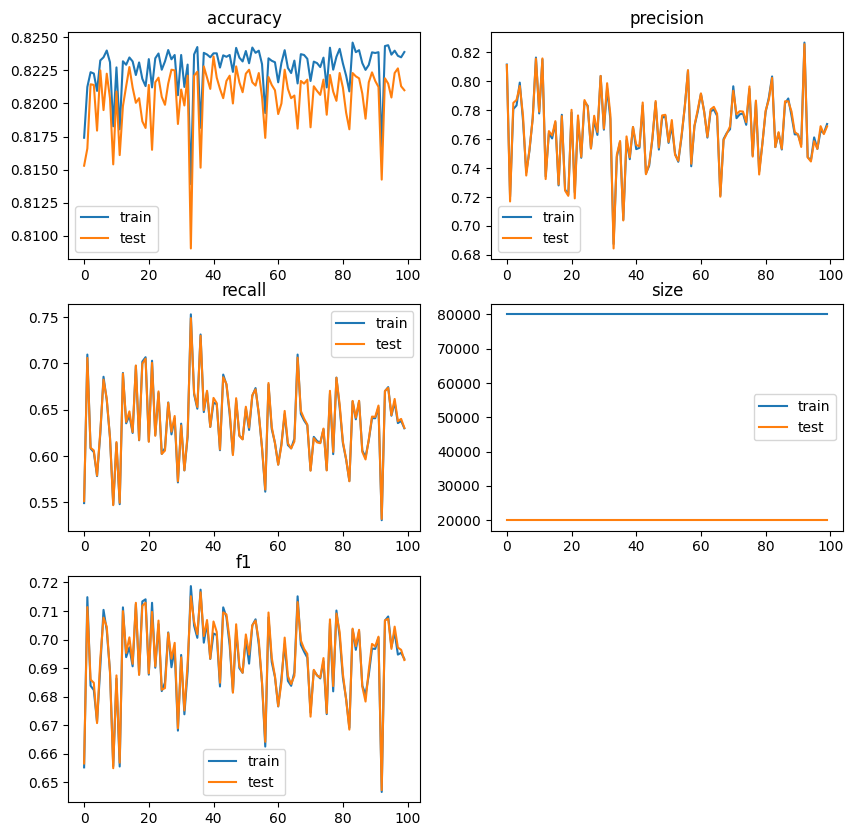

In [51]:
fc_model = nn.Sequential(
    nn.Linear(16, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 2),
)

te = TrainEvalGraphless(fc_model)
te.main(NUM_EPOCH, onehot_train_loader, onehot_test_loader)

# Features: constant, avg_nodes: 15

In [45]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 2
max_degree = 15 

constant = Constant(value=1.0, cat=False)

ds_const = FakeDatasetIsPlanar(num_graphs=NUM_GRAPHS, avg_num_nodes=15, avg_degree=avg_degree,
                               transform=constant)

print(f"Planar graphs: {int(ds_const.y.sum())}")
ds_const

Planar graphs: 31665
CPU times: user 40.3 s, sys: 94.3 ms, total: 40.4 s
Wall time: 40.5 s


FakeDatasetIsPlanar(100000)

In [47]:
ds_const_train_loader, ds_const_test_loader = split_dataset(ds_const)

Number of training graphs: 80000
Number of test graphs: 20000


GCN(
  (conv1): GCNConv(1, 10)
  (conv2): GCNConv(10, 10)
  (conv3): GCNConv(10, 10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  02, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  03, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  04, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  05, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.00

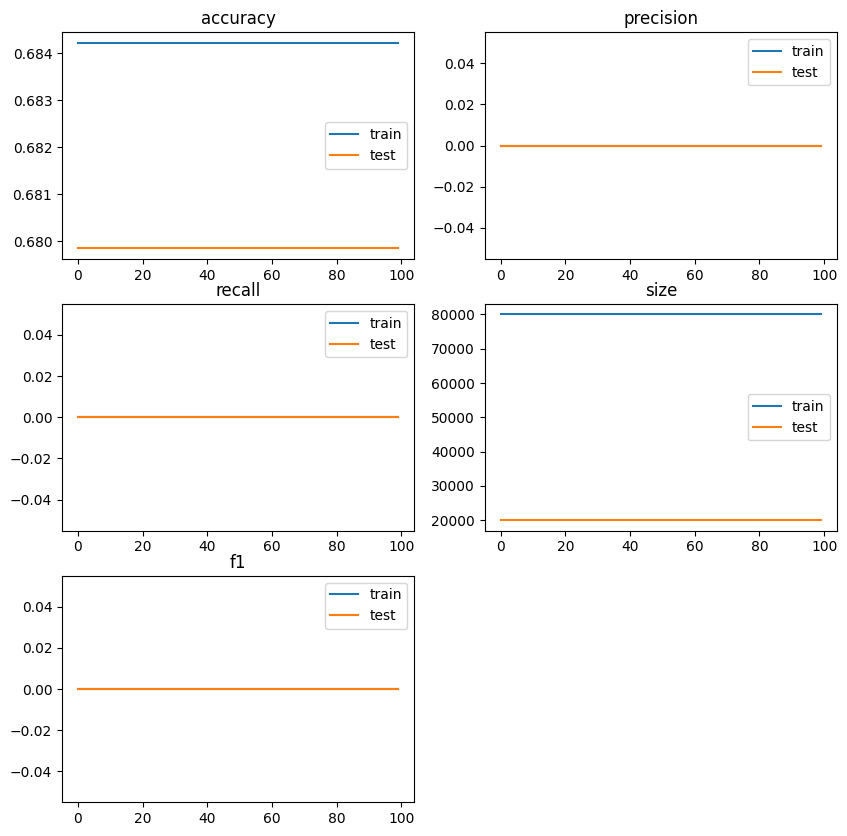

In [48]:
gcn_model = GCN(hidden_channels=10, num_node_features=ds_const.num_node_features,
            num_classes=ds_const.num_classes)
print(gcn_model)

te = TrainEval(gcn_model)
te.main(NUM_EPOCH, ds_const_train_loader, ds_const_test_loader)

SAGE(
  (conv1): SAGEConv(1, 10, aggr=mean)
  (conv2): SAGEConv(10, 10, aggr=mean)
  (conv3): SAGEConv(10, 10, aggr=mean)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  02, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  03, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  04, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, Test: accuracy=0.6798, precision=0.0000, recall=0.0000, size=20000.0000, f1=0.0000
Epoch:  05, Train: accuracy=0.6842, precision=0.0000, recall=0.0000, size=80000.0000, f1=0.0000, 

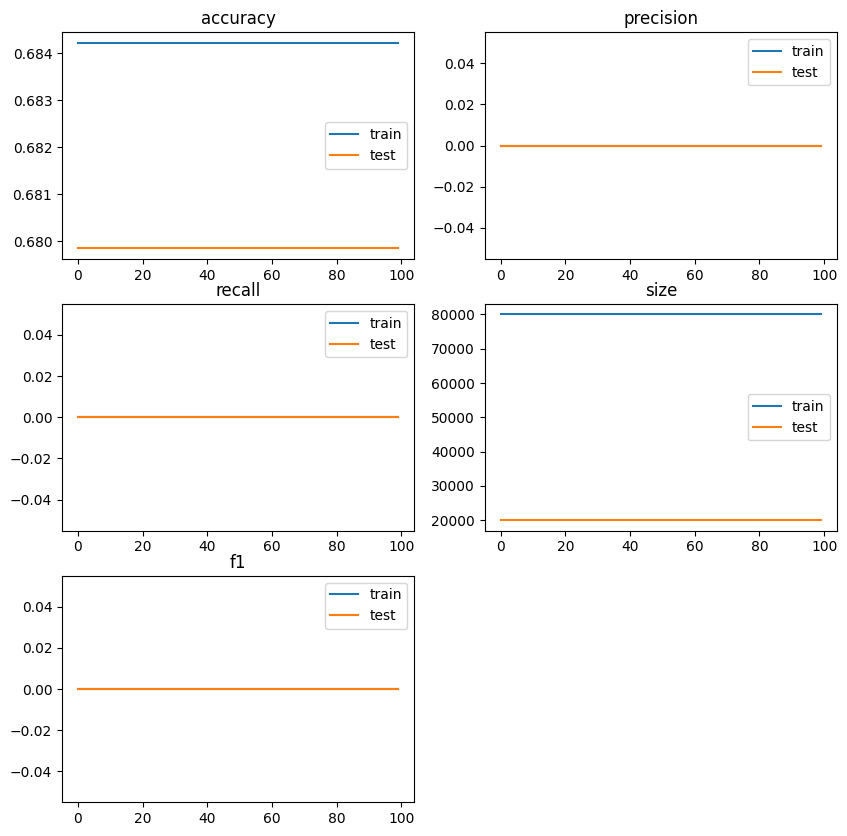

In [49]:
sage_model = SAGE(hidden_channels=10, num_node_features=ds_const.num_node_features,
                  num_classes=ds_const.num_classes)
print(sage_model)

te = TrainEval(sage_model)
te.main(NUM_EPOCH, ds_const_train_loader, ds_const_test_loader)

ConvGNN(
  (conv1): GraphConv(1, 10)
  (conv2): GraphConv(10, 10)
  (conv3): GraphConv(10, 10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7980, precision=0.7524, recall=0.5371, size=80000.0000, f1=0.6267, Test: accuracy=0.7945, precision=0.7514, recall=0.5354, size=20000.0000, f1=0.6253
Epoch:  02, Train: accuracy=0.7983, precision=0.7765, recall=0.5073, size=80000.0000, f1=0.6137, Test: accuracy=0.7956, precision=0.7774, recall=0.5066, size=20000.0000, f1=0.6135
Epoch:  03, Train: accuracy=0.7305, precision=0.5483, recall=0.8321, size=80000.0000, f1=0.6610, Test: accuracy=0.7266, precision=0.5480, recall=0.8321, size=20000.0000, f1=0.6608
Epoch:  04, Train: accuracy=0.7970, precision=0.6960, recall=0.6341, size=80000.0000, f1=0.6636, Test: accuracy=0.7935, precision=0.6946, recall=0.6336, size=20000.0000, f1=0.6627
Epoch:  05, Train: accuracy=0.8006, precision=0.7253, recall=0.5935, size=80000.0000, f1=0.6528, Test: accuracy=0.7974, prec

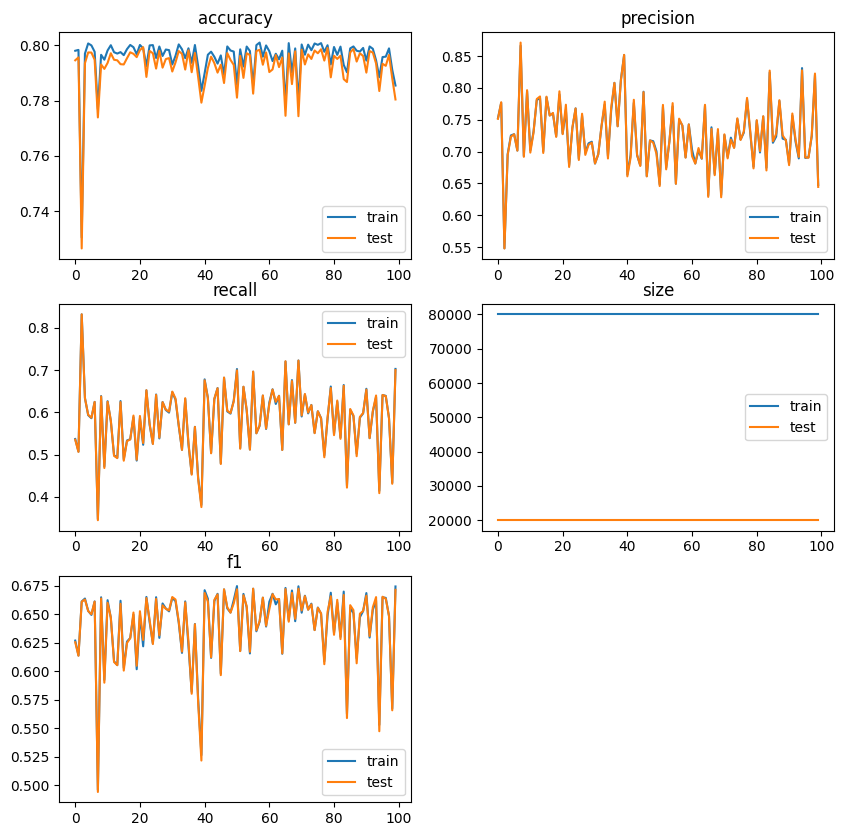

In [50]:
conv_model = ConvGNN(hidden_channels=10, num_node_features=ds_const.num_node_features,
                     num_classes=ds_const.num_classes)
print(conv_model)

te = TrainEval(conv_model)
te.main(NUM_EPOCH, ds_const_train_loader, ds_const_test_loader)